After Dc 2019 I looked backed into nClimGrid by NOAA, and I am happy that they now provide each data variable in a .nc file. Back than I had downloaded a lot of .tar.gz. (one for each month).

# First: Trying Geocube
Since the regionmask has changed since I used it in 2019, I first looked into other new options. GeoCube seemed to be good at first glance, since it is built on top of xarray, rioxarray, geopandas. I tried to rebuild the one sample they have provided in their document into our own problem.

## 2. Applying the method in the example to our problem

### 2.1 Getting the mask data
Following the example, we first get the boundaries. Here we are using a local file in shape format

In [5]:
import geopandas as gpd
import numpy as np
import rioxarray as riox
import xarray as xr

from geocube.api.core import make_geocube

%matplotlib inline

In [6]:
# Now getting the map of Nabraska counties
NE_counties_filepath = r'/Users/babak.jfard/projects/drought_Vulnerability_NE/data/raw/Nebraska_COUNTY/NEBRASKA_COUNTY.shp'
NE_counties = gpd.read_file(NE_counties_filepath)

In [7]:
# keeping only FIPS to be used as Identifier
NE_counties = NE_counties[['FIPS', 'geometry']]
NE_counties.FIPS = NE_counties.FIPS.astype('int')

In [8]:
# Getting the Xarray data
ncd_file = r'/Users/babak.jfard/Downloads/nclimgrid_tavg.nc'
xd = riox.open (ncd_file)

In [27]:
xd_NE = xd.rio.clip(
    NE_counties.geometry.values, crs = NE_counties.geometry.crs, from_disk=True
)
#elevation.name = "elevation"

MissingCRS: CRS not found. Please set the CRS with 'rio.write_crs()'. Data variable: tavg

Well, the example they provided only works on a DataArray. I am looking for a way to directly manipulate the Dataset. Maybe look into it later. It didn't seem much straightforward.

# My Old Method: RegionMask revisited
Once again I returned to use regionmask using its new version, as below.

In [95]:
import xarray as xr
import glob
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt

In [146]:
ncd_file = r'/Users/babak.jfard/Downloads/nclimgrid_tavg.nc'
xd = xr.open_dataset(ncd_file)

In [147]:
xd

<xarray.Dataset>
Dimensions:  (lat: 596, lon: 1385, time: 1550)
Coordinates:
  * time     (time) datetime64[ns] 1895-01-01 1895-02-01 ... 2024-02-01
  * lat      (lat) float32 49.35 49.31 49.27 49.23 ... 24.69 24.65 24.6 24.56
  * lon      (lon) float32 -124.7 -124.6 -124.6 -124.6 ... -67.1 -67.06 -67.02
Data variables:
    tmin     (time, lat, lon) float32 ...
Attributes: (12/14)
    date_created:              2024-01-05 10:53:00.532168
    date_modified:             2024-01-05 10:53:00.532308
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

In [148]:
# Now getting the map of Nabraska counties
NE_counties_filepath = r'/Users/babak.jfard/projects/drought_Vulnerability_NE/data/raw/Nebraska_COUNTY/NEBRASKA_COUNTY.shp'
NE_counties = gpd.read_file(NE_counties_filepath)

#nClimGrid is using Mercator
NE_counties = NE_counties.to_crs(crs="EPSG:4326")

In [149]:
# Extracting the required lat/lon ranges for Nebraska
# Getthing the bounds from NE map
bounds = NE_counties.total_bounds
print(bounds)
lon_min = bounds[0]-0.05
lon_max = bounds[2]+0.05
lat_min = bounds[1]-0.05
lat_max = bounds[3]+0.05

# will add more than 5km on each side to cut
lon = np.arange (lon_min, lon_max)
lat = np.arange(lat_min, lat_max)

[-104.05351441   39.9999969   -95.30829064   43.0017138 ]


In [151]:
# reducing xd size to cover only Nebraska, therefore decreasing computational cost!
xd = xd.sel(time=slice('2010-01-01', '2022-12-31'), lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))

In [152]:
xd

<xarray.Dataset>
Dimensions:  (lat: 74, lon: 212, time: 156)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
  * lat      (lat) float32 43.02 42.98 42.94 42.9 ... 40.1 40.06 40.02 39.98
  * lon      (lon) float32 -104.1 -104.0 -104.0 -103.9 ... -95.35 -95.31 -95.27
Data variables:
    tmin     (time, lat, lon) float32 ...
Attributes: (12/14)
    date_created:              2024-01-05 10:53:00.532168
    date_modified:             2024-01-05 10:53:00.532308
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

## Perform Zonal Statistics with Regonmask

In [153]:
NE_counties['FIPS'] = NE_counties['FIPS'].astype('int16')
NE_counties['FIPS']

0     31003
1     31011
2     31021
3     31023
4     31025
      ...  
88    31047
89    31037
90    31079
91    31043
92    31173
Name: FIPS, Length: 93, dtype: int16

In [154]:
import regionmask

# Create mask of multiple regions from shapefile
NE_mask = regionmask.mask_3D_geopandas(
    NE_counties,
    xd.lon,
    xd.lat,
    drop=True,
    numbers='FIPS'
)

In [155]:
# Apply mask on the dataset
xd = xd.where(NE_mask)

In [156]:
xd

<xarray.Dataset>
Dimensions:  (lat: 74, lon: 212, region: 93, time: 156)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
  * lat      (lat) float32 43.02 42.98 42.94 42.9 ... 40.1 40.06 40.02 39.98
  * lon      (lon) float32 -104.1 -104.0 -104.0 -103.9 ... -95.35 -95.31 -95.27
  * region   (region) int64 31001 31003 31005 31007 ... 31179 31181 31183 31185
Data variables:
    tmin     (time, lat, lon, region) float32 nan nan nan nan ... nan nan nan
Attributes: (12/14)
    date_created:              2024-01-05 10:53:00.532168
    date_modified:             2024-01-05 10:53:00.532308
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east

In [157]:
grouped_xd = xd.groupby('time').mean(['lat', 'lon'])
grouped_xd

<xarray.Dataset>
Dimensions:  (region: 93, time: 156)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
  * region   (region) int64 31001 31003 31005 31007 ... 31179 31181 31183 31185
Data variables:
    tmin     (time, region) float32 -10.7 -12.97 -9.42 ... -10.27 -11.23 -10.45

In [158]:
df = grouped_xd.to_dataframe().reset_index().rename(columns= {'region':'FIPS'})

In [159]:
df

,FIPS,time,tmin
0,31001,2010-01-01,-10.698470
1,31001,2010-02-01,-8.847222
2,31001,2010-03-01,-0.296332
3,31001,2010-04-01,5.345356
4,31001,2010-05-01,8.380555
...,...,...,...
14503,31185,2022-08-01,16.669989
14504,31185,2022-09-01,12.103149
14505,31185,2022-10-01,3.278176
14506,31185,2022-11-01,-4.719227


It looks like worked very well. Let's plot a few sample maps of a cold and a hot month.

In [120]:
# Get an example to make sure this is working
df_1 = df[df['time']=='2010-02-01']
NE_sample_1 = NE_counties.merge(df_1, on='FIPS')

<AxesSubplot:>

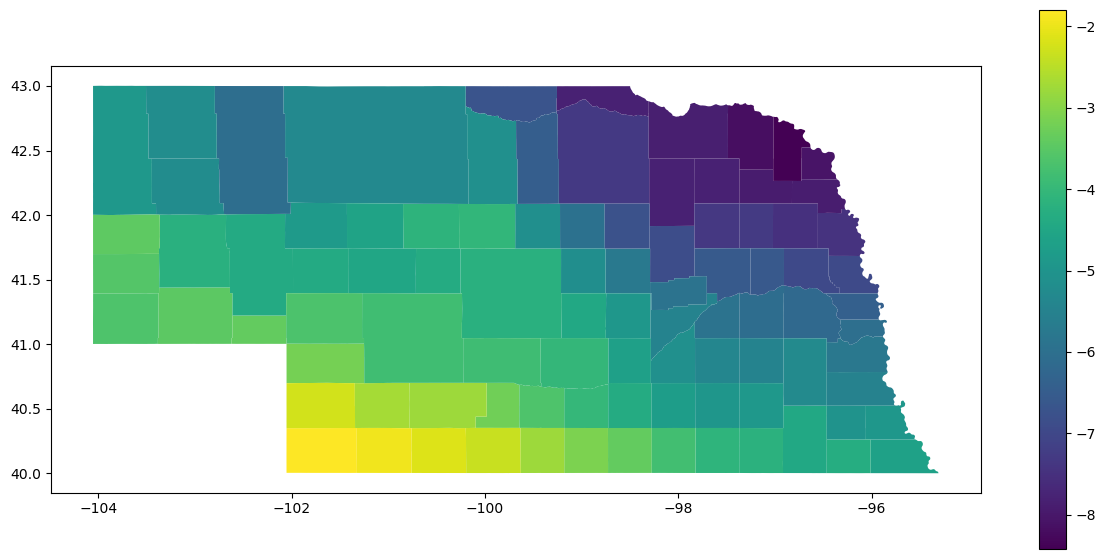

In [121]:
NE_sample_1.plot(column='tavg', figsize=(15,7), legend=True)

<AxesSubplot:>

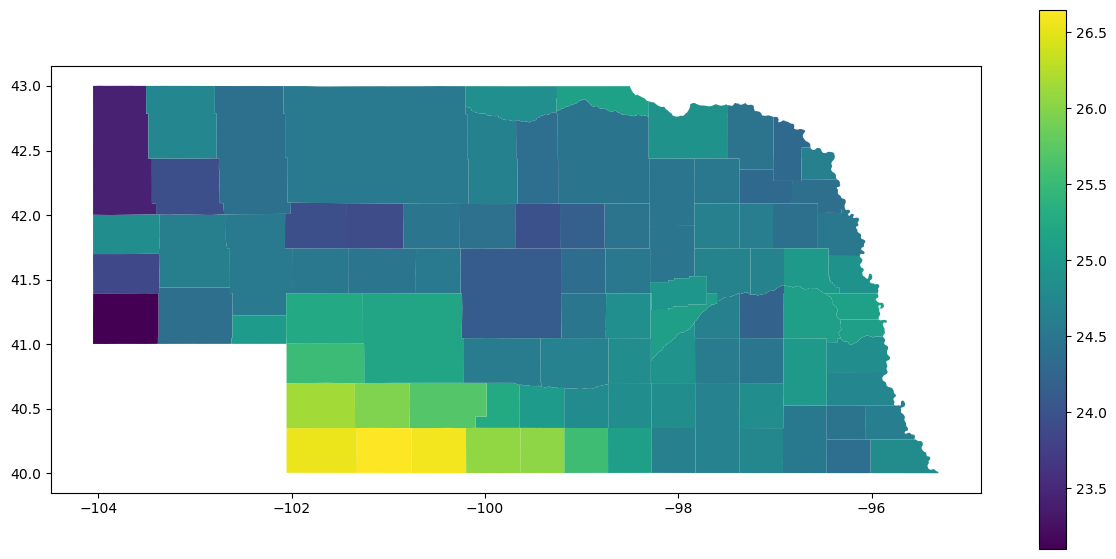

In [119]:
df_2 = df[df['time']== '2022-07-01']
NE_sample_2 = NE_counties.merge(df_2, on='FIPS')
NE_sample_2.plot(column='tavg', figsize=(15,7), legend=True)

## Factorizing the Code
Making the code reusable. Will later add it into a python library

In [127]:
def mask_with_regionMask(the_xrDataset, the_map, id_column, the_crs="EPSG:4326", 
                         longitude_name='lon', latitude_name= 'lat'):
    # Change the map crs to the Xarray crs
    the_map = the_map.to_crs(crs="EPSG:4326")
    # Create mask of multiple regions from shapefile
    the_mask = regionmask.mask_3D_geopandas(
        the_map,
        xd[longitude_name], # Later will make it general
        xd[latitude_name], 
        drop=True,
        numbers= id_column
    )
    the_xrDataset = the_xrDataset.where(the_mask)
    return(the_xrDataset)

In [128]:
test = mask_with_regionMask(xd, NE_counties, 'FIPS')

In [129]:
test

<xarray.Dataset>
Dimensions:  (lat: 74, lon: 212, region: 93, time: 156)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2022-12-01
  * lat      (lat) float32 43.02 42.98 42.94 42.9 ... 40.1 40.06 40.02 39.98
  * lon      (lon) float32 -104.1 -104.0 -104.0 -103.9 ... -95.35 -95.31 -95.27
  * region   (region) int64 31001 31003 31005 31007 ... 31179 31181 31183 31185
Data variables:
    tavg     (time, lat, lon, region) float32 nan nan nan nan ... nan nan nan
Attributes: (12/14)
    date_created:              2024-01-05 11:04:55.312427
    date_modified:             2024-01-05 11:04:55.312582
    Conventions:               CF-1.6, ACDD-1.3
    ncei_template_version:     NCEI_NetCDF_Grid_Template_v2.0
    title:                     nClimGrid
    naming_authority:          gov.noaa.ncei
    ...                        ...
    geospatial_lat_min:        24.562532
    geospatial_lat_max:        49.3542
    geospatial_lon_min:        -124.6875
    geospatial_lon_max:        -67.020836
    geospatial_lat_units:      degrees_north
    geospatial_lon_units:      degrees_east